# ДЗ №6 - автокодировщики для идентификации аномалий

В этом ДЗ вам предстоит применить модель сврточного автокодировщика для идентификации аномалий в данных.

In [1]:
# Эту ячейку следует выоплнять в окружении, в котором еще не установлены необходимые библиотеки. В подготовленном окружении эту ячейку можно пропустить.
!pip3 install torch torchvision numpy matplotlib

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image

from typing import Tuple, List, Type, Dict, Any

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### **Задание: Напишите пайплайн для предобработки и аугументации данных**.


In [4]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(degrees=30),
    torchvision.transforms.ToTensor()
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

В предположении, что файл данных `mnist_corrupted.npz` загружен и находится в той же директории, что и этот нотбук, генераторы данных можно описать следующим образом:

In [5]:
class DS(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]

        if self.transform:
            x = Image.fromarray(x.astype(np.uint8))
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.data)

In [6]:
mnist = np.load('./mnist_corrupted.npz')
mnist_train_samples = mnist['x_train']
mnist_test_samples = mnist['x_test']
train_dataset = DS(mnist_train_samples, train_transforms)
val_dataset = DS(mnist_test_samples, val_transforms)

### **Визуализация исходных данных**

Как и в любой задаче, имеет смысл визуализировать исходные данные, чтобы понимать, с чем мы имеем дело

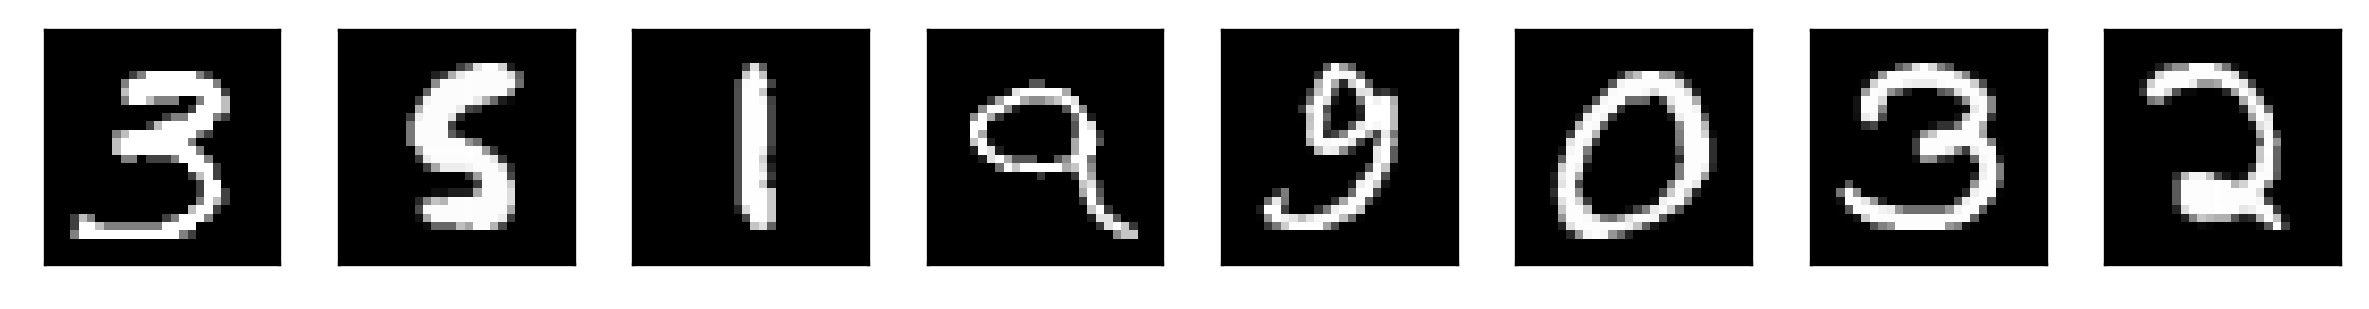

In [7]:
indices = np.random.randint(0, len(train_dataset), size=8)

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(8, 2), dpi=300)
for i, ax in enumerate(axes):
    sample_index = indices[i]
    sample = mnist_train_samples[sample_index]
    ax.imshow(sample, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
fig.patch.set_facecolor('white')

### **Задание: отобразите несколько произвольных примеров обучающей выборки.**

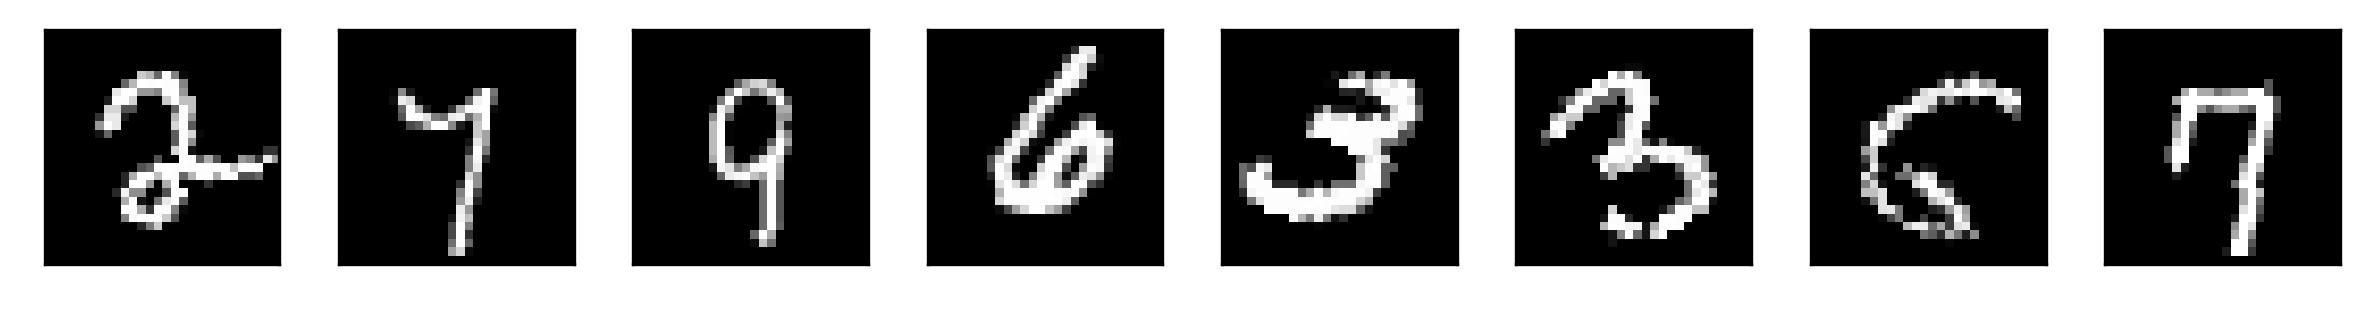

In [8]:
indices = np.random.randint(0, len(train_dataset), size=8)

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(8, 2), dpi=300)
for i, ax in enumerate(axes):
    sample_index = indices[i]
    sample = train_dataset[sample_index]
    ax.imshow(np.squeeze(sample.cpu().numpy()), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
fig.patch.set_facecolor('white')

### **Задание:  Описать класс нейросети-автокодировщика, описываемой в этом задании.**

In [9]:
class ConvAutoencoder(nn.Module):
    def __init__(self, hidden_dim = 16):
        super(ConvAutoencoder, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, padding=1, stride=2)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1, stride=2)
        self.l1 = nn.Linear(196, hidden_dim)

        self.l2 = nn.Linear(hidden_dim, 196)
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 3, padding=1, stride=1)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 3, padding=1, stride=1)
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x_shape = x.shape
        x = x.view((-1, np.product(x.shape[1:])))
        x = F.relu(self.l1(x))

        x = F.relu(self.l2(x))
        x = x.view([-1] + list(x_shape[1:]))
        x = F.upsample(x, scale_factor=(2, 2), mode='bilinear')
        x = F.relu(self.t_conv1(x))
        x = F.upsample(x, scale_factor=(2, 2), mode='bilinear')
        x = F.sigmoid(self.t_conv2(x))

        return x

In [10]:
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (l1): Linear(in_features=196, out_features=16, bias=True)
  (l2): Linear(in_features=16, out_features=196, bias=True)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [11]:
model = model.to(device)

### **Задание: отобразите один произвольный пример обучающей выборки и результат вычисления нейросети на этом примере.**

In [12]:
example_index = int(np.random.randint(0, len(train_dataset), size=1))
example = train_dataset[example_index]

example_np = np.squeeze(example.detach().cpu().numpy())
example_transformed = model(example.view(1,1,28,28).to(device))
example_transformed_np = np.squeeze(example_transformed.detach().cpu().numpy())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


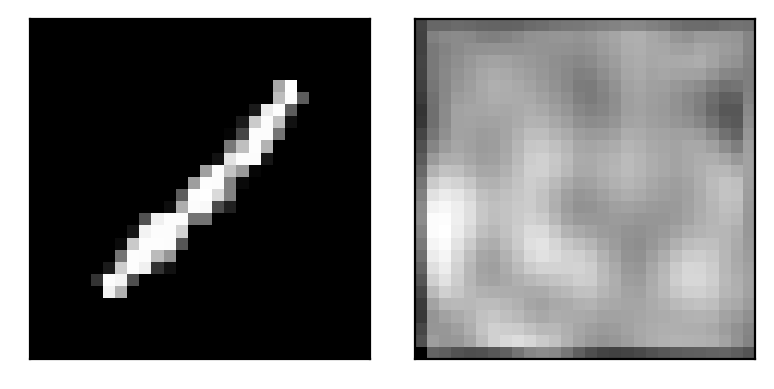

In [13]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (4,2), dpi = 200)
for i, ax in enumerate(axes):
    img = example_np if i==0 else example_transformed_np
    ax.imshow(img, cmap = 'gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
fig.patch.set_facecolor('white')

### **Обучение модели**


In [14]:
def train_model(model: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                val_dataset: torch.utils.data.Dataset,
                loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim.Adam,
                optimizer_params: Dict = {},
                initial_lr = 0.01,
                lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau,
                lr_scheduler_params: Dict = {},
                batch_size = 64,
                max_epochs = 15,
                early_stopping_patience = 10
):
    optimizer = optimizer_class(model.parameters(), **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

    best_val_loss = None
    best_epoch = None
    # threshold = 0
    
    for epoch in range(max_epochs):
        print(f'Epoch {epoch+1} of {max_epochs}')
        train_single_epoch(model, optimizer, loss_function, train_loader)
        val_metrics = validate_single_epoch(model, loss_function, val_loader)
        print(f'Validation metrics: \n{val_metrics}')

        lr_scheduler.step(val_metrics['loss'])
        
        if best_val_loss is None or best_val_loss > val_metrics['loss']:
            print(f'Best model yet, saving')
            best_val_loss = val_metrics['loss']
            best_epoch = epoch
            
        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            return

### **Задание:  Реализуйте функцию, производящую обучение сети на протяжении одной эпохи ( полного прохода по всей обучающей выборке ). На вход будет приходить модель, оптимизатор, функция потерь и объект типа `DataLoader`.**

In [15]:
def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer, 
                       loss_function: torch.nn.Module, 
                       data_loader: torch.utils.data.DataLoader):
    
    model.train()

    for X_batch in data_loader:
        X_batch = X_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = loss_function(output, X_batch) 
        
        loss.backward()
        optimizer.step()

### **Задание:  Реализуйте функцию производящую расчёт функции потерь на тестовой выборке.  На вход будет приходить модель, функция потерь и DataLoader.**

In [16]:
@torch.no_grad()
def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module, 
                          data_loader: torch.utils.data.DataLoader):
    model.eval()
    loss_history = 0

    for X_batch in data_loader:
        X_batch = X_batch.to(device)
        
        output = model(X_batch)
        loss_history += loss_function(output, X_batch).item()

    return {
        'loss': loss_history / len(data_loader.dataset)
    }

### **Задание: придумайте функцию потерь.**


Наша цель получить идентичное преобразование. Идентичное преобразование тем ближе, чем меньше MSE. В качестве функции потерь выбрана MSE.

In [18]:
train_model(model, 
            train_dataset=train_dataset, 
            val_dataset=val_dataset, 
            loss_function=nn.MSELoss(reduction='sum'), 
            max_epochs = 20,
            initial_lr=0.0001)

Epoch 1 of 20


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation metrics: 
{'loss': 25.7250241607666}
Best model yet, saving
Epoch 2 of 20
Validation metrics: 
{'loss': 23.805596295166016}
Best model yet, saving
Epoch 3 of 20
Validation metrics: 
{'loss': 22.328310488891603}
Best model yet, saving
Epoch 4 of 20
Validation metrics: 
{'loss': 21.832313958740233}
Best model yet, saving
Epoch 5 of 20
Validation metrics: 
{'loss': 21.48837980957031}
Best model yet, saving
Epoch 6 of 20
Validation metrics: 
{'loss': 20.217894799804686}
Best model yet, saving
Epoch 7 of 20
Validation metrics: 
{'loss': 19.930016381835937}
Best model yet, saving
Epoch 8 of 20
Validation metrics: 
{'loss': 19.45395402832031}
Best model yet, saving
Epoch 9 of 20
Validation metrics: 
{'loss': 19.40828217468262}
Best model yet, saving
Epoch 10 of 20
Validation metrics: 
{'loss': 19.00617671508789}
Best model yet, saving
Epoch 11 of 20
Validation metrics: 
{'loss': 18.76587667236328}
Best model yet, saving
Epoch 12 of 20
Validation metrics: 
{'loss': 18.61452719116211

Для лучшей модели получено значение loss=17,8119 на валидационной выборке. Далее будем применять её для идентификации аномалий.

## **Проверка результатов**

In [21]:
index = int(np.random.randint(0, len(train_dataset), size=1))
sample = train_dataset[index][0]
sample_np = np.squeeze(sample.detach().cpu().numpy())
sample_ae = model(sample.view(1,1,28,28).to(device))
sample_ae_np = np.squeeze(sample_ae.detach().cpu().numpy())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


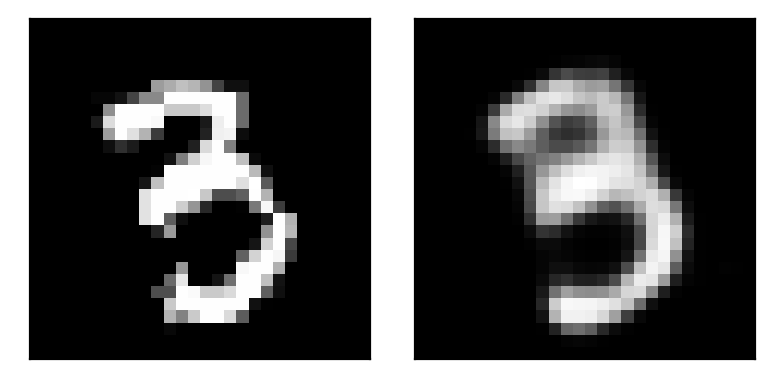

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 2), dpi=200)
for i, ax in enumerate(axes):
    img = sample_np if i==0 else sample_ae_np
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
fig.patch.set_facecolor('white')
plt.imshow(img, cmap='gray')

## **Идентификация аномалий.**

### **Задание: примените обученную модель автокодировщика к данным тестовой выборки. Вычислите функцию потерь на каждом объекте тестовой выборки.**

In [23]:
model.eval()
test_dataset = DS(mnist_test_samples, val_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
loss_function = nn.MSELoss(reduction='sum')

losses = []

with torch.no_grad():
    with tqdm(total=len(test_loader)) as pbar:
        for data in test_loader:
            data = data.to(device)
            output = model(data)
            curr_loss = loss_function(output, data).item()
            losses.append(curr_loss)
            pbar.set_postfix({'loss' : curr_loss})
            pbar.update(1)

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 10000/10000 [00:57<00:00, 174.33it/s, loss=20.6]


## **Анализ значений функции потерь**

### Задание:
- Отобразите гистограмму значений функции потерь. Сделайте выводы (напишите ТЕКСТ) относительно значений для обычных объектов и аномалий.
- Найдите объекты-аномалии, отобразите их.
- Вычислите на них обученный вами автокодировщик. Отобразите рядом объекты-аномалии и их реконструкцию, вычисленную вашим автокодировщиком.

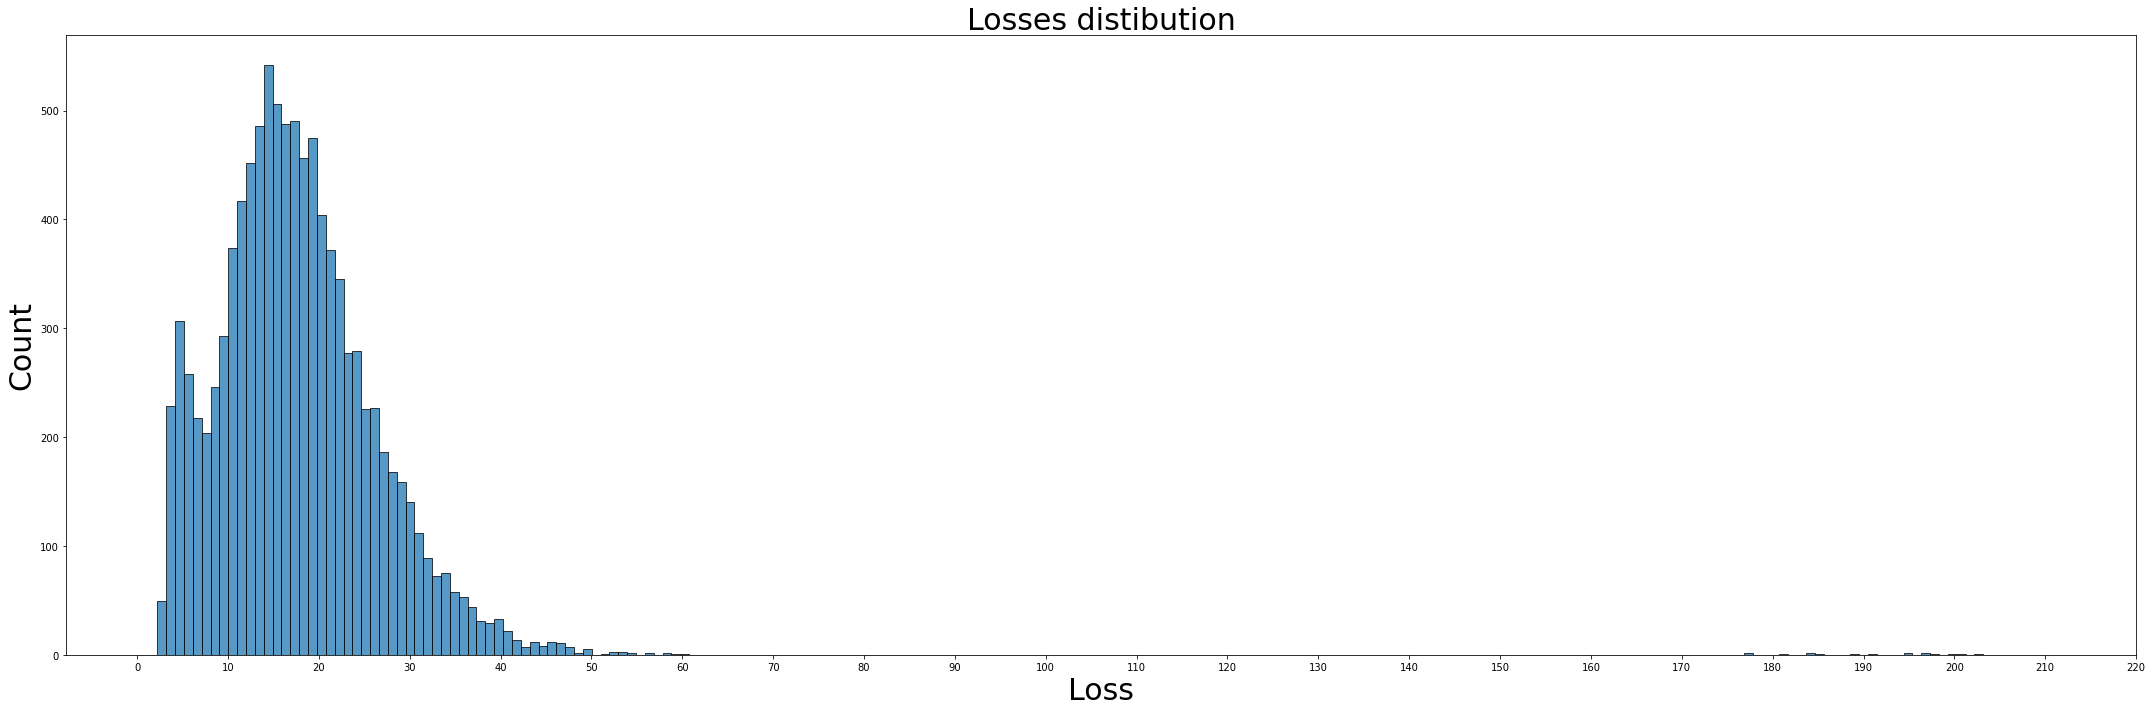

In [25]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(30,10))
sns.histplot(losses)
ax.set_title('Losses distibution', fontsize = 30)
ax.set_xlabel('Loss', fontsize = 30)
ax.set_ylabel('Count', fontsize = 30)
ax.set_xticks(np.arange(0, 230, step = 10))
plt.tight_layout()

По гистограмме значений функции потерь можем заметить, что нормальными являются значения от 0 до 63. Далее при повышением порога от 63, рассматривая при этом аномальные исходы, приходим к выводу, что последним похожим на цифру изображением является изображение с loss = 68. Таким образом, мы экспериментально подобрали пороговое значение функции потерь: threshold = 70.

In [29]:
threshold = 70
anomalies = []
for i, loss in enumerate(losses) :
    if loss > threshold : 
        anomalies.append((i, loss))
print(f'Anomalies: {len(anomalies)}\nTest dataset size: {len(losses)}')

Anomalies: 16
Test dataset size: 10000


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


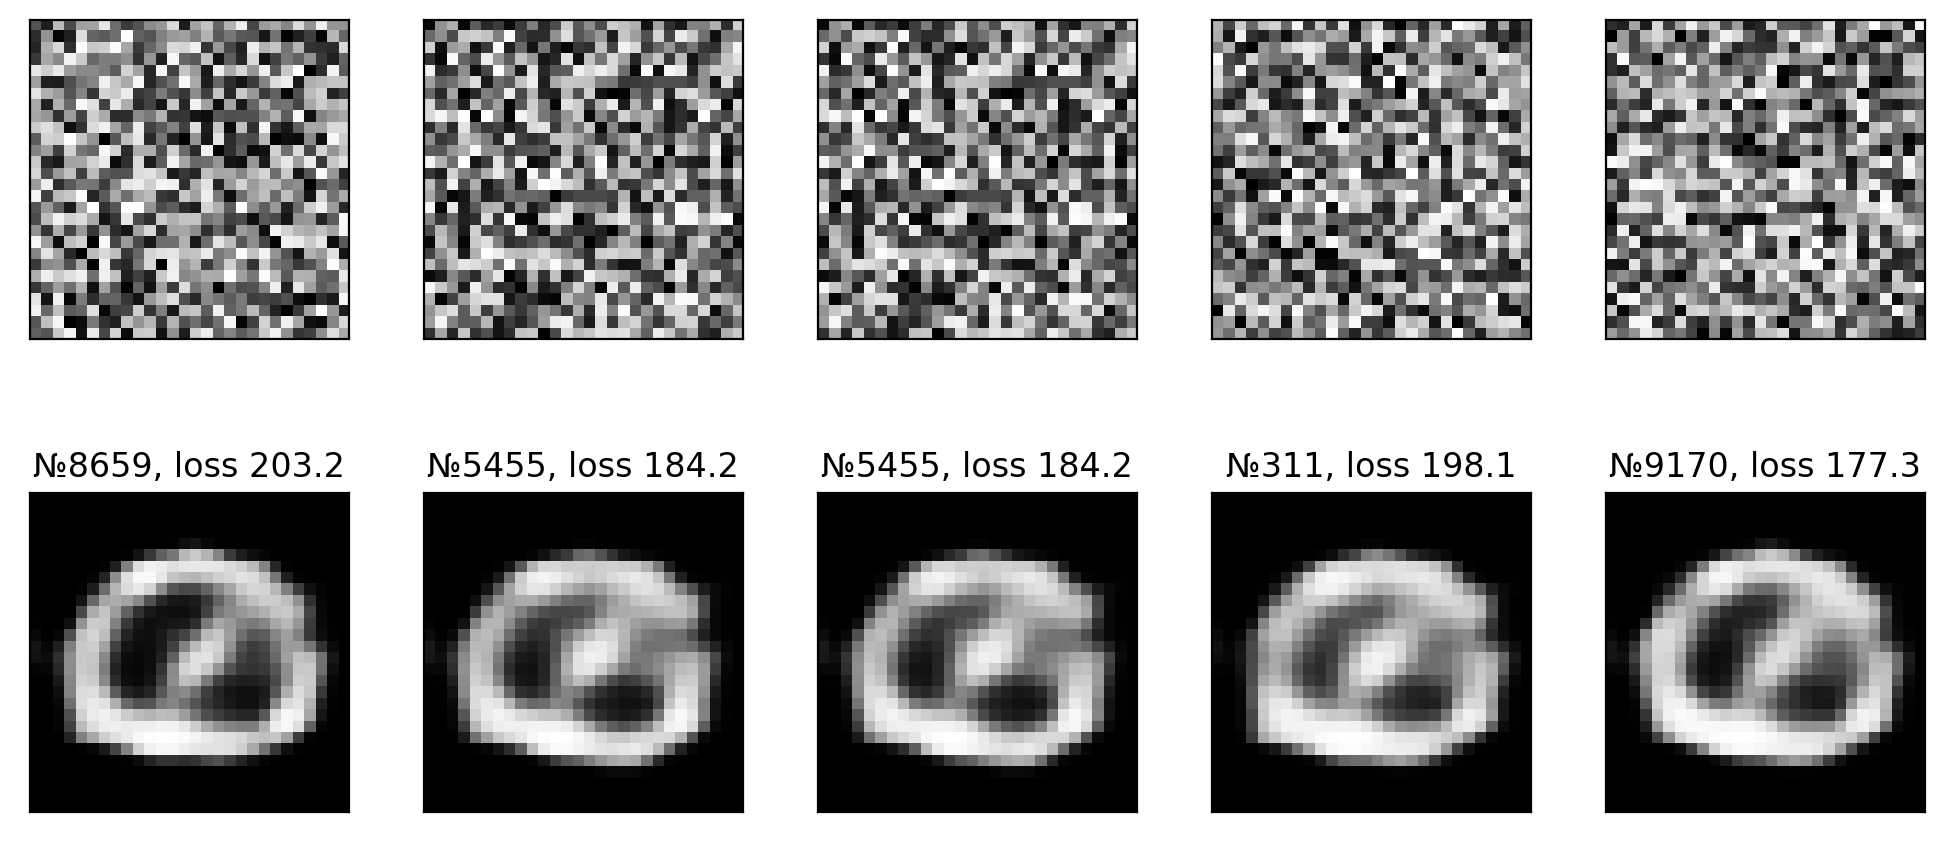

In [27]:
indices = np.random.randint(0, len(anomalies), size=5)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5), dpi=200)
for i in range(5) :
    sample_index = anomalies[indices[i]][0]
    loss = anomalies[indices[i]][1]
    sample = test_dataset[sample_index]
    sample = sample.unsqueeze_(0)
    axes[0][i].imshow(np.squeeze(sample), cmap='gray')
    axes[0][i].set_xticks([])
    axes[0][i].set_yticks([])

    model.eval()
    sample = sample.to(device)
    with torch.no_grad() :
      output = model(sample)
    axes[1][i].set_title('№{}, loss {:.1f}'.format(sample_index, loss))
    axes[1][i].imshow(np.squeeze(output.cpu().numpy()), cmap='gray')
    axes[1][i].set_xticks([])
    axes[1][i].set_yticks([])
plt.tight_layout()
fig.patch.set_facecolor('white')

### **Задание: создайте файл маркировки аномалий**

In [31]:
answer = np.zeros((len(test_dataset)))

for tmp in anomalies:
    index = tmp[0]
    answer[index] = 1

np.savetxt('result.txt', answer, newline='', delimiter='', fmt='%d')